In [1]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
import os
import pickle
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)  # Suppress harmless runtime warnings

In [ ]:
def compute_betti_numbers(graph_matrix, percentage=95):
    """
    Compute Betti numbers from adjacency matrix
    
    Parameters:
        graph_matrix: Adjacency matrix
        threshold: Threshold for converting matrix to graph
        
    Returns:
        dict: Dictionary containing Betti0 and Betti1
    """
    try:
        # Apply threshold to create graph structure
        graph = defaultdict(list)
        n = graph_matrix.shape[0]
        threshold = np.percentile(graph_matrix, percentage)
        # target_density = 0.1
        # sorted_vals = np.sort(graph_matrix.flatten())
        # threshold = sorted_vals[int((1 - target_density) * len(sorted_vals))]

        for i in range(n):
            for j in range(i+1, n):  # Avoid duplicates and undirected graph bidirectional edges
                if graph_matrix[i,j] >= threshold:
                    graph[i].append(j)
                    graph[j].append(i)
        
        # Calculate number of connected components (Betti0)
        visited = set()
        components = 0
        
        for node in graph:
            if node not in visited:
                components += 1
                # Use BFS to traverse connected component
                queue = [node]
                while queue:
                    current = queue.pop(0)
                    if current not in visited:
                        visited.add(current)
                        queue.extend(graph[current])
        
        # Calculate Betti1 (number of cycles)
        # Using Euler's formula: Betti1 = edges - vertices + components
        num_vertices = len(graph)
        num_edges = sum(len(edges) for edges in graph.values()) // 2  # Undirected graph counts each edge twice
        
        betti_1 = num_edges - num_vertices + components
        
        return {
            'betti_0': components,
            'betti_1': max(betti_1, 0)  # Ensure non-negative
        }
        
    except Exception as e:
        print(f"Error computing Betti numbers: {str(e)}")
        return {
            'betti_0': np.nan,
            'betti_1': np.nan
        }

def topological_analysis(network, percentage=95):
    """Graph theory based topological analysis function"""
    try:
        # Data preprocessing
        network = np.abs(network)
        network = (network - np.nanmin(network)) / (np.nanmax(network) - np.nanmin(network) + 1e-6)
        
        # Compute Betti numbers
        betti_result = compute_betti_numbers(network, percentage)
        
        return {
            'betti_0': betti_result['betti_0'],
            'betti_1': betti_result['betti_1']
        }
    except Exception as e:
        print(f"Topological analysis error: {str(e)}")
        return {
            'betti_0': np.nan,
            'betti_1': np.nan
        }

In [3]:
def load_network_data(results_folder='results', network_type='TE', atom_type='xty'):
    """
    Load network data and organize into structured dictionary
    
    Parameters:
        results_folder: Path containing .pkl result files
        network_type: Network type ('TE' or 'PhiID')
        atom_type: For PhiID networks, specify atom type
        
    Returns:
        dict: {
            'rest': {source: [matrix1, matrix2,...]},  # Rest condition data
            'conditions': {cond_name: {source: [matrix1, matrix2,...]}},  # Other condition data
            'roi_names': list,  # List of ROI names
            'metadata': {
                'network_type': str,
                'atom_type': str
            }
        }
    """
    print("\n" + "="*50)
    print("Starting network data loading")
    print(f"Results folder: {results_folder}")
    print(f"Network type: {network_type}")
    print(f"Atom type: {atom_type}")
    print("="*50)
    
    result_files = glob.glob(os.path.join(results_folder, '*.pkl'))
    if not result_files:
        raise FileNotFoundError(f"No result files (.pkl) found in folder {results_folder}")
    
    print(f"\nFound {len(result_files)} result files:")
    for i, f in enumerate(result_files[:5]):
        print(f"  {i+1}. {os.path.basename(f)}")
    if len(result_files) > 5:
        print(f"  ... (Total {len(result_files)} files)")
    
    data = {
        'rest': defaultdict(list),
        'conditions': defaultdict(lambda: defaultdict(list)),
        'roi_names': None,
        'metadata': {
            'network_type': network_type,
            'atom_type': atom_type
        }
    }
    
    for file_idx, filepath in enumerate(sorted(result_files), 1):
        print(f"\nProcessing file {file_idx}/{len(result_files)}: {os.path.basename(filepath)}")
        try:
            with open(filepath, 'rb') as f:
                results = pickle.load(f)
            
            # Get condition name
            cond = results.get('metadata', {}).get('selected_conditions', os.path.basename(filepath))
            if isinstance(cond, list):
                cond = cond[0] if len(cond) > 0 else os.path.basename(filepath)
            print(f"Condition name: {cond}")
            
            # Get ROI information
            if data['roi_names'] is None:
                data['roi_names'] = results['metadata']['roi_names']
                n_rois = len(data['roi_names'])
                print(f"Number of ROIs: {n_rois}")
                print(f"First 5 ROI names: {data['roi_names'][:5]}")
            
            # Collect matrices for all sources in this condition
            source_matrices = defaultdict(list)
            roi_pairs = results.get('conditions', {}).get(cond, {}).get('roi_pairs', {})
            print(f"Number of ROI pairs: {len(roi_pairs)}")
            
            for pair_idx, (pair_key, pair_data) in enumerate(roi_pairs.items(), 1):
                if not isinstance(pair_data, dict) or 'error' in pair_data:
                    continue
                
                # Get trial_sources for current ROI pair
                sources = []
                if network_type == 'TE' and 'TE' in pair_data and 'trial_sources' in pair_data['TE']:
                    sources = pair_data['TE']['trial_sources']
                elif network_type == 'PhiID' and 'PhiID' in pair_data and 'trial_sources' in pair_data['PhiID']:
                    sources = pair_data['PhiID']['trial_sources']
                elif 'PID' in pair_data and 'trial_sources' in pair_data['PID']:
                    sources = pair_data['PID']['trial_sources']
                
                if not sources:
                    continue
                    
                # Get trial-level values
                if network_type == 'TE':
                    trial_values = pair_data.get('TE', {}).get('values', [])
                elif network_type == 'PhiID':
                    trial_values = pair_data.get('PhiID', {}).get('trial_values', {}).get(atom_type, [])
                else:
                    trial_values = []
                
                # Build matrix for each trial
                src_idx, tgt_idx = pair_data['roi_info']['indices']
                for trial_idx, val in enumerate(trial_values):
                    if trial_idx >= len(sources):
                        continue
                    source = sources[trial_idx]
                    # Ensure enough matrices exist
                    while len(source_matrices[source]) <= trial_idx:
                        source_matrices[source].append(np.zeros((n_rois, n_rois)))
                    source_matrices[source][trial_idx][src_idx, tgt_idx] = val
            
            # Separate Rest from other conditions
            if 'rest' in cond.lower():
                print(f"Identified as Rest condition")
                data['rest'] = source_matrices
            else:
                print(f"Identified as experimental condition: {cond}")
                data['conditions'][cond] = source_matrices
            
            # Print loading statistics for current file
            print(f"Loaded sources: {len(source_matrices)}")
            for src, matrices in list(source_matrices.items())[:3]:
                print(f"  source '{src}': {len(matrices)} matrices")
            if len(source_matrices) > 3:
                print(f"  ... (Total {len(source_matrices)} sources)")
                
        except Exception as e:
            print(f"Error processing file {os.path.basename(filepath)}: {str(e)}")
            continue
    
    # Validate data completeness
    print("\n>>> Data completeness check <<<")
    if not data['rest']:
        raise ValueError("No Rest condition data found")
    else:
        print(f"Rest condition data loaded successfully, contains {len(data['rest'])} sources")
    
    if not data['conditions']:
        raise ValueError("No other condition data found")
    else:
        print(f"Loaded {len(data['conditions'])} experimental conditions:")
        for cond, sources in data['conditions'].items():
            print(f"  {cond}: {len(sources)} sources")
    
    print("\nData loading complete!")
    return data

In [ ]:
def analyze_topological_features(data, percentage=95):
    """Final analysis pipeline with complete edge case handling"""
    all_results = {
        'rest': defaultdict(dict),
        'conditions': defaultdict(dict),
        'comparisons': defaultdict(dict)
    }
    
    # Process Rest condition
    for source, matrices in data['rest'].items():
        try:
            avg_matrix = np.nanmean(matrices, axis=0)
            all_results['rest'][source] = topological_analysis(avg_matrix, percentage)
        except:
            all_results['rest'][source] = {
                'betti_0': np.nan,
                'betti_1': np.nan
            }
    
    # Process each condition
    for cond, source_dict in data['conditions'].items():
        for source, matrices in source_dict.items():
            try:
                avg_matrix = np.nanmean(matrices, axis=0)
                all_results['conditions'][cond][source] = topological_analysis(avg_matrix, percentage)
            except:
                all_results['conditions'][cond][source] = {
                    'betti_0': np.nan,
                    'betti_1': np.nan
                }
    
    # Comparison calculation (only Betti numbers)
    for cond in data['conditions']:
        common_sources = set(all_results['rest'].keys()) & set(all_results['conditions'][cond].keys())
        
        betti_0_diffs = []
        betti_1_diffs = []
        
        for src in common_sources:
            rest_res = all_results['rest'][src]
            cond_res = all_results['conditions'][cond][src]
            
            # Ensure all values are valid
            if all(not np.isnan(rest_res[k]) and not np.isnan(cond_res[k]) for k in ['betti_0', 'betti_1']):
                betti_0_diffs.append(cond_res['betti_0'] - rest_res['betti_0'])
                betti_1_diffs.append(cond_res['betti_1'] - rest_res['betti_1'])
        
        # Ensure lists are not empty
        betti_0_diffs = betti_0_diffs if betti_0_diffs else [np.nan]
        betti_1_diffs = betti_1_diffs if betti_1_diffs else [np.nan]
        
        all_results['comparisons'][cond] = {
            'betti_0_diff': betti_0_diffs,
            'betti_1_diff': betti_1_diffs,
            'mean_betti_0_diff': np.nanmean(betti_0_diffs),
            'mean_betti_1_diff': np.nanmean(betti_1_diffs),
            'n_sources': len(common_sources)
        }
    
    return all_results

In [ ]:
# 1. Load data
print("\n" + "="*50)
print("Main program started")
print("="*50)

print("\n>>> Step 1: Loading network data <<<")
network_data = load_network_data(results_folder='results', network_type='TE')

# Examine a sample network
sample_matrix = network_data['rest'][list(network_data['rest'].keys())[0]][0]
print("Network value statistics:")
print(f"Minimum: {np.min(sample_matrix):.4f}")
print(f"Maximum: {np.max(sample_matrix):.4f}")
print(f"Mean: {np.mean(sample_matrix):.4f}")
print(f"Non-zero ratio: {np.count_nonzero(sample_matrix)/sample_matrix.size:.2%}")

# Print loaded data summary
print("\nLoaded data summary:")
print(f"Number of ROI names: {len(network_data['roi_names'])}")
print(f"Rest condition sources: {len(network_data['rest'])}")
print(f"Experimental conditions: {len(network_data['conditions'])}")
for cond in network_data['conditions']:
    print(f"  Condition '{cond}': {len(network_data['conditions'][cond])} sources")

# 2. Perform topological analysis
print("\n>>> Step 2: Performing topological analysis <<<")
topo_results = analyze_topological_features(network_data,98.25)

# 3. Print results
print("\n>>> Step 3: Printing final results <<<")
print("\n=== Topological Analysis Results ===")

# Print Rest condition results
print("\nRest condition:")
rest_betti_0 = [res['betti_0'] for res in topo_results['rest'].values()]
rest_betti_1 = [res['betti_1'] for res in topo_results['rest'].values()]
print(f"  Betti-0 (connected components): {np.mean(rest_betti_0):.1f} ± {np.std(rest_betti_0):.1f}")
print(f"  Betti-1 (loops): {np.mean(rest_betti_1):.1f} ± {np.std(rest_betti_1):.1f}")

# Print condition results
for cond in topo_results['conditions']:
    cond_betti_0 = [res['betti_0'] for res in topo_results['conditions'][cond].values()]
    cond_betti_1 = [res['betti_1'] for res in topo_results['conditions'][cond].values()]
    print(f"\nCondition: {cond}")
    print(f"  Betti-0 (connected components): {np.mean(cond_betti_0):.1f} ± {np.std(cond_betti_0):.1f}")
    print(f"  Betti-1 (loops): {np.mean(cond_betti_1):.1f} ± {np.std(cond_betti_1):.1f}")

# Print comparison results
for cond, comp in topo_results['comparisons'].items():
    print(f"\nComparison {cond} vs Rest:")
    print(f"  Betti-0 difference: {comp['mean_betti_0_diff']:.1f} ({comp['n_sources']} sources)")
    print(f"  Betti-1 difference: {comp['mean_betti_1_diff']:.1f} ({comp['n_sources']} sources)")


Main program started

>>> Step 1: Loading network data <<<

Starting network data loading
Results folder: results
Network type: TE
Atom type: xty

Found 10 result files:
  1. results_Rest.pkl
  2. results_VISp (L).pkl
  3. results_SSp-ul_ll (R).pkl
  4. results_VISa_rl (R).pkl
  5. results_RSPd_v (Bilateral).pkl
  ... (Total 10 files)

Processing file 1/10: results_AUD (L).pkl
Condition name: AUD (L)
Number of ROIs: 130
First 5 ROI names: ['FRP (R)', 'ACAd (R)', 'ACAv (R)', 'PL (R)', 'ILA (R)']
Number of ROI pairs: 16770
Identified as experimental condition: AUD (L)
Loaded sources: 8
  source '2': 14 matrices
  source '4': 14 matrices
  source '6': 14 matrices
  ... (Total 8 sources)

Processing file 2/10: results_MOp (L).pkl
Condition name: MOp (L)
Number of ROI pairs: 16770
Identified as experimental condition: MOp (L)
Loaded sources: 7
  source '2': 7 matrices
  source '6': 7 matrices
  source '3': 7 matrices
  ... (Total 7 sources)

Processing file 3/10: results_MOs (R).pkl
Condit

In [ ]:
def plot_topological_results(results, network_type='TE', save_path='./'):
    """Visualize topological results with separate figures for each metric and save as PDF"""
    # Data preparation
    plot_data = []
    for cond_type in ['rest', 'conditions']:
        if cond_type == 'rest':
            for source, res in results['rest'].items():
                plot_data.append({
                    'Condition': 'Rest',
                    'Source': source,
                    'Betti_0': res['betti_0'],
                    'Betti_1': res['betti_1']
                })
        else:
            for cond, sources in results['conditions'].items():
                for source, res in sources.items():
                    plot_data.append({
                        'Condition': cond,
                        'Source': source,
                        'Betti_0': res['betti_0'],
                        'Betti_1': res['betti_1']
                    })
    
    df = pd.DataFrame(plot_data)
    
    # Create and save figures for each metric
    def create_and_save_figure(y_col, title, filename_suffix):
        plot_df = df.dropna(subset=[y_col])
        if plot_df.empty:
            print(f"No valid data for {title}")
            return
        
        fig, ax = plt.subplots(figsize=(6, 5))
        
        sns.boxplot(
            data=plot_df, x='Condition', y=y_col, 
            ax=ax, palette='viridis',
            hue='Condition', legend=False
        )
        sns.stripplot(data=plot_df, x='Condition', y=y_col,
                    color='black', alpha=0.5, ax=ax, jitter=True)
        
        ax.set_xlabel('') 
        ax.set_ylabel(title) 
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        plt.tight_layout()
        
        filename = f"{network_type}_{filename_suffix}.pdf"
        full_path = f"{save_path.rstrip('/')}/{filename}"
        fig.savefig(full_path, format='pdf', bbox_inches='tight')
        plt.show(fig)
        print(f"Saved figure to: {full_path}")
    
    create_and_save_figure('Betti_0', "Betti-0 (Connected Components)", "betti_0")
    create_and_save_figure('Betti_1', "Betti-1 (Loops)", "betti_1")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

def create_combined_plots(results, save_path='./'):
    """Create combined visualizations and save as PDF"""
    
    # Prepare heatmap data (calculate Betti number differences between conditions)
    conditions = sorted(results['conditions'].keys())
    n_conds = len(conditions)
    betti_data = {
        'B0': np.zeros((n_conds, n_conds)),
        'B1': np.zeros((n_conds, n_conds))
    }
    
    # Create annotation matrices (empty strings on diagonal)
    annot_B0 = np.empty((n_conds, n_conds), dtype=object)
    annot_B1 = np.empty((n_conds, n_conds), dtype=object)
    
    # Create significance masks (cells with p<0.05)
    sig_mask_B0 = np.zeros((n_conds, n_conds), dtype=bool)
    sig_mask_B1 = np.zeros((n_conds, n_conds), dtype=bool)
    
    for i, cond1 in enumerate(conditions):
        for j, cond2 in enumerate(conditions):
            # Calculate Betti-0
            data1 = [res['betti_0'] for res in results['conditions'][cond1].values()]
            data2 = [res['betti_0'] for res in results['conditions'][cond2].values()]
            _, pval = stats.mannwhitneyu(data1, data2)
            betti_data['B0'][i,j] = -np.log10(pval)
            annot_B0[i,j] = f"{-np.log10(pval):.1f}" if i != j else ""
            sig_mask_B0[i,j] = (pval > 0.05) and (i != j)
            
            # Calculate Betti-1
            data1 = [res['betti_1'] for res in results['conditions'][cond1].values()]
            data2 = [res['betti_1'] for res in results['conditions'][cond2].values()]
            _, pval = stats.mannwhitneyu(data1, data2)
            betti_data['B1'][i,j] = -np.log10(pval)
            annot_B1[i,j] = f"{-np.log10(pval):.1f}" if i != j else ""
            sig_mask_B1[i,j] = (pval > 0.05) and (i != j)

    # Create diagonal mask (for gray background)
    diagonal_mask = np.eye(n_conds, dtype=bool)
    
    # Plot Betti-0 heatmap
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(betti_data['B0'], 
                    annot=annot_B0,
                    fmt="s",
                    xticklabels=conditions,
                    yticklabels=conditions,
                    cmap="YlOrRd",
                    cbar_kws={'label': '-log10(p)'},
                    mask=diagonal_mask)
    
    # Add gray patches for diagonal and non-significant cells
    for i in range(n_conds):
        for j in range(n_conds):
            if i == j:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, 
                                         color=(0.9, 0.9, 0.9),
                                         linewidth=0.5, 
                                         edgecolor='gray'))
            elif sig_mask_B0[i,j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, 
                                         color=(0.8, 0.8, 0.8),
                                         linewidth=0.5, 
                                         edgecolor='gray'))
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{save_path.rstrip('/')}/betti0_heatmap.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    
    # Plot Betti-1 heatmap
    plt.figure(figsize=(6, 4))
    ax = sns.heatmap(betti_data['B1'], 
                    annot=annot_B1,
                    fmt="s",
                    xticklabels=conditions,
                    yticklabels=conditions,
                    cmap="YlOrRd",
                    cbar_kws={'label': '-log10(p)'},
                    mask=diagonal_mask)
    
    # Add gray patches for diagonal and non-significant cells
    for i in range(n_conds):
        for j in range(n_conds):
            if i == j:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, 
                                         color=(0.9, 0.9, 0.9),
                                         linewidth=0.5, 
                                         edgecolor='gray'))
            elif sig_mask_B1[i,j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, 
                                         color=(0.8, 0.8, 0.8),
                                         linewidth=0.5, 
                                         edgecolor='gray'))
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f"{save_path.rstrip('/')}/betti1_heatmap.pdf", format='pdf', bbox_inches='tight')
    plt.show()
    
    print(f"Saved heatmaps to: {save_path}betti0_heatmap.pdf and {save_path}betti1_heatmap.pdf")


>>> Step 4: Visualizing results <<<


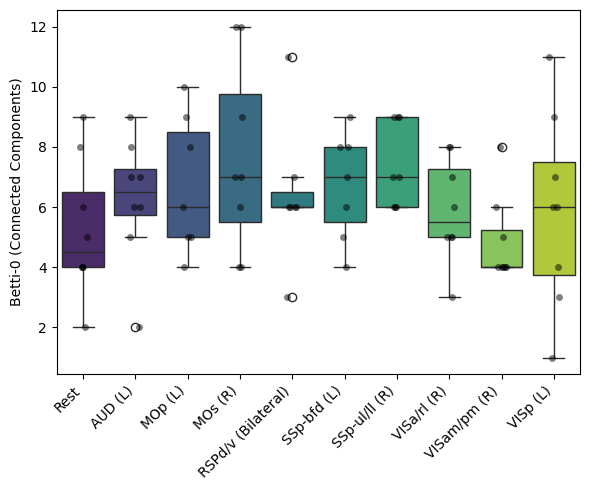

Saved figure to: ./TE_betti_0.pdf


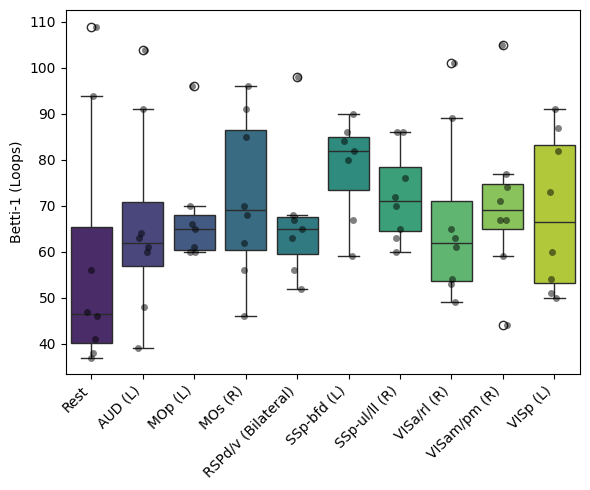

Saved figure to: ./TE_betti_1.pdf


/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_83698/3281137455.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_83698/3281137455.py:68: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,


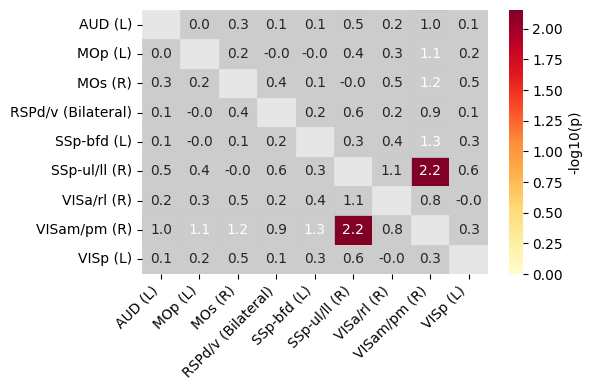

/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_83698/3281137455.py:94: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,
/var/folders/wc/806vr9fd2b3cbmkr46kx891h0000gn/T/ipykernel_83698/3281137455.py:100: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True,


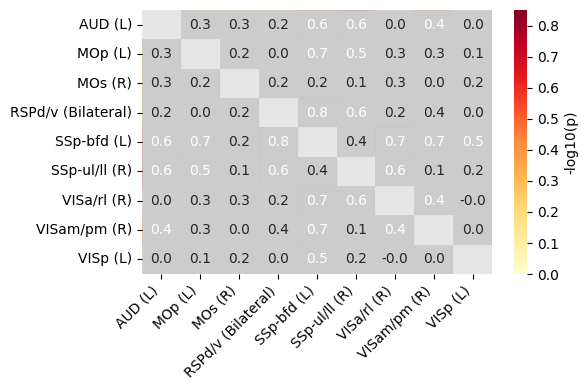

Saved heatmaps to: ./betti0_heatmap.pdf and ./betti1_heatmap.pdf

Analysis complete!


In [ ]:
# 4. Visualization
print("\n>>> Step 4: Visualizing results <<<")
fig = plot_topological_results(topo_results, network_type='TE')
fig = create_combined_plots(topo_results)
plt.show()

print("\nAnalysis complete!")